In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
  def __init__(self,channels_img,features_d):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
        #input=N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img,features_d,kernel_size=4,stride=2,padding=1
        ),#32x32
        nn.LeakyReLU(0.2),
        self._block(features_d,features_d*2,4,2,1),#16x16
        self._block(features_d*2,features_d*4,4,2,1),#8x8
        self._block(features_d*4,features_d*8,4,2,1),#4x4
        nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0),#1x1
        nn.Sigmoid(),

    )

  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size,
                  stride,
                  padding,
                  bias=False,
                  ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),

    )
  def forward(self,x):
    return self.disc(x)

In [3]:

class Generator(nn.Module):
  def __init__(self,z_dim,channels_img,features_g):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
        #ip= N x Z_dim x 1 x 1
        self._block(z_dim,features_g*16,4,1,0),#4x4
        self._block(features_g*16,features_g*8,4,2,1),#8x8
        self._block(features_g*8,features_g*4,4,2,1),#16x16
        self._block(features_g*4,features_g*2,4,2,1),#32x32
        nn.ConvTranspose2d(
            features_g*2,channels_img,kernel_size=4,stride=2,padding=1,#64x64
        ),
        nn.Tanh(),

    )
  def _block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),


    )
  def forward(self,x):
    return self.gen(x)


In [4]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

In [5]:
def test():
  N,in_channels,H,W=8,3,64,64
  z_dim=100
  x=torch.randn((N,in_channels,H,W))
  disc=Discriminator(in_channels,8)
  initialize_weights(disc)
  #asserts confirms the o/p shape is n,1,1,1
  assert disc(x).shape==(N,1,1,1)
  gen=Generator(z_dim,in_channels,8)
  initialize_weights(gen)
  z=torch.randn((N,z_dim,1,1))
  assert gen(z).shape==(N,in_channels,H,W)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [7]:

#hp
LEARNING_RATE=2e-4
BATCH_SIZE=128
IMAGE_SIZE=64
CHANNELS_IMG=1
Z_DIM=100
NUM_EPOCHS=5
FEATURES_DISC=64
FEATURES_GEN=64

transforms=transforms.Compose(
    [
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)]),
    ]
    )


In [8]:
dataset=datasets.MNIST(root="datasets/",train=True,transform=transforms,download=True)

loader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
gen=Generator(Z_DIM,CHANNELS_IMG,FEATURES_GEN)
disc=Discriminator(CHANNELS_IMG,FEATURES_DISC)
initialize_weights(gen)
initialize_weights(disc)

opt_gen=optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_disc=optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
criterion=nn.BCELoss()

fixed_noise=torch.randn(32,Z_DIM,1,1)

100%|██████████| 9912422/9912422 [00:00<00:00, 133549979.58it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8346702.53it/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37194610.01it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2816875.46it/s]


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [9]:
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
  for batch_idx,(real,_) in enumerate(loader):
    #train disc
    #same as before
    noise=torch.randn((BATCH_SIZE,Z_DIM,1,1))
    fake=gen(noise)
    #log(D(real))
    disc_real=disc(real).reshape(-1)
    loss_disc_real=criterion(disc_real,torch.ones_like(disc_real))
    #log(1-D(G(z)))
    disc_fake=disc(fake).reshape(-1)
    loss_disc_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
    loss_disc=(loss_disc_real + loss_disc_fake)/2
    disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()

    #gen
    output=disc(fake).reshape(-1)
    loss_gen=criterion(output,torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

     # Output training stats
    if batch_idx% 100 == 0:
      print(
          f"Epoch[{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)}\
          Loss D:{loss_disc:.4f},loss G:{loss_gen:.4f}"
      )


Epoch[0/5] Batch 0/469          Loss D:0.6916,loss G:0.7730
Epoch[0/5] Batch 100/469          Loss D:0.0150,loss G:4.0875
Epoch[0/5] Batch 200/469          Loss D:0.4734,loss G:1.8763
Epoch[0/5] Batch 300/469          Loss D:0.6344,loss G:2.2341


KeyboardInterrupt: ignored

```
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Number of images to generate in the grid
num_images = 32

# Generate random noise vectors
fixed_noise = torch.randn(num_images, Z_DIM, 1, 1)

# Set the generator to evaluation mode
gen.eval()

# Generate images from the noise
with torch.no_grad():
    generated_images = gen(fixed_noise)

# Set the generator back to training mode
gen.train()

# Create a grid of generated images
grid = vutils.make_grid(generated_images, nrow=8, normalize=True, padding=2)

# Visualize the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
```

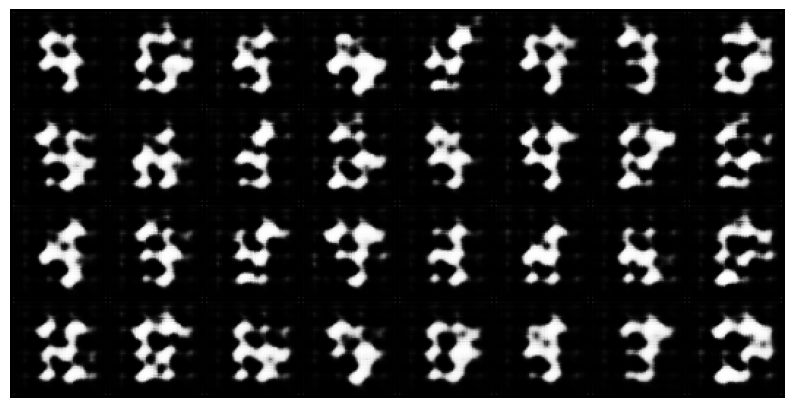

In [10]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Number of images to generate in the grid
num_images = 32

# Generate random noise vectors
fixed_noise = torch.randn(num_images, Z_DIM, 1, 1)

# Set the generator to evaluation mode
gen.eval()

# Generate images from the noise
with torch.no_grad():
    generated_images = gen(fixed_noise)

# Set the generator back to training mode
gen.train()

# Create a grid of generated images
grid = vutils.make_grid(generated_images, nrow=8, normalize=True, padding=2)

# Visualize the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()